In [1]:
#importing data manipulation libraries
import pandas as pd
import numpy as np

#importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


#importing logging
import logging
logging.basicConfig(filename = 'car_price.log', level = logging.INFO,filemode='w', format = '%(asctime)s %(levelname)s %(message)s')

#importing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
url="https://raw.githubusercontent.com/Frisk516/car_price_MLModel/refs/heads/main/CAR%20DETAILS%20FROM%20CAR%20DEKHO.csv"
df=pd.read_csv(url)
df.sample(frac=1)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
2205,Maruti 800 Std BSII,2006,90000,40000,Petrol,Individual,Manual,Second Owner
83,Nissan Terrano XL,2014,650000,76000,Petrol,Individual,Manual,Second Owner
1227,Tata Indica Vista TDI LS,2013,210000,135000,Diesel,Dealer,Manual,Second Owner
3057,Maruti Alto LXi,2012,180000,40000,Petrol,Individual,Manual,Second Owner
3566,Hyundai Creta 1.6 SX,2019,1200000,1200,Petrol,Individual,Manual,First Owner
...,...,...,...,...,...,...,...,...
2485,Maruti Alto K10 VXI AGS,2015,281000,4432,Petrol,Dealer,Automatic,Second Owner
3119,Chevrolet Aveo 1.4,2007,85000,70000,Petrol,Individual,Manual,Second Owner
3441,Maruti Wagon R VXI BS IV,2016,375000,30000,Petrol,Individual,Manual,Second Owner
125,Maruti Swift Vdi BSIII,2007,100000,110000,Diesel,Individual,Manual,Fourth & Above Owner


In [3]:
#separating numerical and categorical data
numerical_data=df.select_dtypes(exclude=object)
categorial_data=df.select_dtypes(include=object)

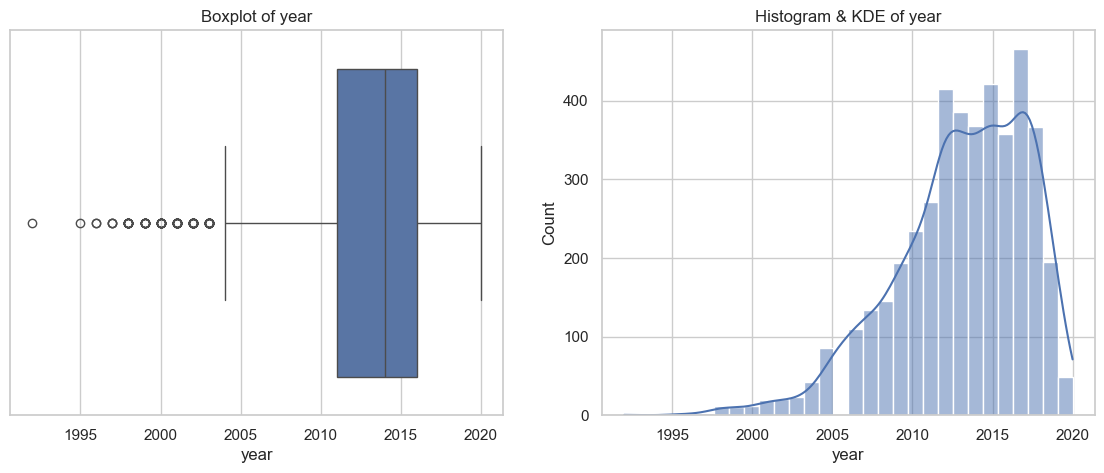

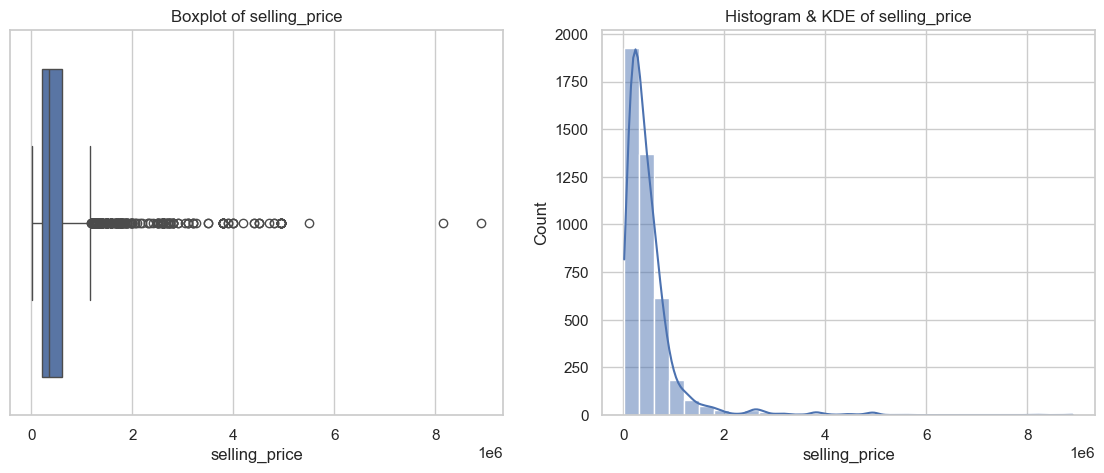

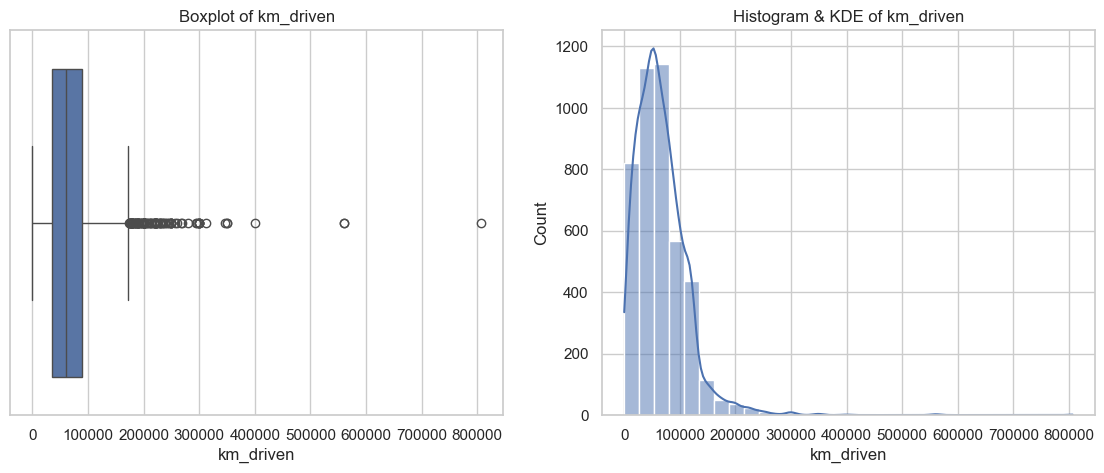

In [4]:
# Set plot style
sns.set(style="whitegrid")

# Plot boxplots and bell curves for each numerical feature
for col in numerical_data.columns:
    plt.figure(figsize=(14, 5))
    
    # Boxplot (shows outliers as points beyond whiskers)
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    
    # Bell curve: histogram + KDE (to check distribution shape)
    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram & KDE of {col}')
    
    plt.show()

In [5]:
#performing EDA

from collections import OrderedDict
stats=[]
for i in numerical_data:
    numerical_stats=OrderedDict({
        'feature':i,
        'mean':df[i].mean(),
        'median':df[i].median(),
        'mode':df[i].mode()[0],
        'std':df[i].std(),
        'min':df[i].min(),
        'max':df[i].max(),
        'skewness':df[i].skew(),
        'kurtosis':df[i].kurt()
    })
    stats.append(numerical_stats)
    report=pd.DataFrame(stats)


# Outlier Identification :
outlier_label = []
for col in report['feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # LW : Lower Whisker Line
    UW = Q3 + 1.5 * IQR   # UW : Upper Whisker Line
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    if not outliers.empty:
        outlier_label.append("Has Outliers")
    else:
        outlier_label.append("No Outliers")

report["Outlier Comment"] = outlier_label

# Checking Report
report

,feature,mean,median,mode,std,min,max,skewness,kurtosis,Outlier Comment
0,year,2013.090783,2014.0,2017,4.215344,1992,2020,-0.833240,0.668263,Has Outliers
1,selling_price,504127.311751,350000.0,300000,578548.736139,20000,8900000,4.892021,37.087543,Has Outliers
2,km_driven,66215.777419,60000.0,70000,46644.102194,1,806599,2.669057,23.316809,Has Outliers


In [6]:
#using labelencoder to encode name,fuel,seller_type,transmission,owner

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['name']=le.fit_transform(categorial_data['name'])
df['fuel']=le.fit_transform(categorial_data['fuel'])
df['seller_type']=le.fit_transform(categorial_data['seller_type'])
df['transmission']=le.fit_transform(categorial_data['transmission'])
df['owner']=le.fit_transform(categorial_data['owner'])

df.head()


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,775,2007,60000,70000,4,1,1,0
1,1041,2007,135000,50000,4,1,1,0
2,505,2012,600000,100000,1,1,1,0
3,118,2017,250000,46000,4,1,1,0
4,279,2014,450000,141000,1,1,1,2


In [8]:
#train test split to prevent data leak

from sklearn.model_selection import train_test_split
X=df.drop('selling_price',axis=1)
y=df['selling_price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=7)

In [9]:
#since data has a lot of outliers,we will be using robustscaler

from sklearn.preprocessing import RobustScaler
scaler=RobustScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [11]:
#using linear regression

from sklearn.linear_model import LinearRegression

LR=LinearRegression()

LR.fit(X_train,y_train)

y_pred_LR=LR.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

r2_score_LR=r2_score(y_test,y_pred_LR)
r2_score_LR

0.4457466637782712

In [12]:
from sklearn.ensemble import RandomForestRegressor

RF=RandomForestRegressor()

RF.fit(X_train,y_train)

y_pred_RF=RF.predict(X_test)

r2_score_RF = r2_score(y_test,y_pred_RF)
print(f'The R2 Score for ',r2_score_RF)

The R2 Score for  0.818964293743907


In [13]:
from sklearn.tree import DecisionTreeRegressor

DT=DecisionTreeRegressor()

DT.fit(X_train,y_train)

y_pred_DT=DT.predict(X_test)

r2_score_DT=r2_score(y_test,y_pred_DT)
r2_score_DT

0.7319673730435069

In [14]:
#checking Model Performance 

mse_LR =mean_squared_error(y_test, y_pred_LR)
mse_DT= mean_squared_error(y_test, y_pred_DT)

mae_LR = mean_absolute_error(y_test, y_pred_LR)
mae_DT = mean_absolute_error(y_test, y_pred_DT)

print(f'The mean squared error for Linear Regression Model: {mse_LR}')

print(f'The mean absolute error for Linear Regression Model: {mae_LR}')

print(f'The mean squared error for Decision Tree Model: {mse_DT}')

print(f'The mean absolute error for Decision Tree Model: {mae_DT}')

The mean squared error for Linear Regression Model: 145959249676.82077
The mean absolute error for Linear Regression Model: 227304.64264122277
The mean squared error for Decision Tree Model: 70584764335.68326
The mean absolute error for Decision Tree Model: 113612.82616487457


In [15]:
#Using XGB Bossting Algorithm

import xgboost as xgb

XGB = xgb.XGBRegressor()

XGB.fit(X_train, y_train)

y_pred_XGB = XGB.predict(X_test)

r2_score_XGB = r2_score(y_test, y_pred_XGB)

print(f'The R2 Score for XGBoost Model: {r2_score_XGB}')

The R2 Score for XGBoost Model: 0.8765507340431213


In [16]:
from sklearn.ensemble import AdaBoostRegressor
ADA=AdaBoostRegressor()

ADA.fit(X_train, y_train)

y_pred_ADA = ADA.predict(X_test)

r2_score_ADA = r2_score(y_test, y_pred_ADA)

print(f'The R2 Score for AdaBoost Model: {r2_score_ADA}')

The R2 Score for AdaBoost Model: 0.47613944336174197


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define model and parameter grid
model=RandomForestRegressor(random_state=42)
param_grid = {'n_estimators': [25,50,100, 200, 300, 400,500],'max_depth': [None, 10,20,30,40,50]}

#Grid Search Cv
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

#print result
print('Best Parameters:', grid_search.best_params_)
print('R2 Score:', r2_score(y_test, y_pred))

Best Parameters: {'max_depth': 20, 'n_estimators': 50}
R2 Score: 0.8012948981254123


In [ ]:
#XGboost gave the best score
